# Predicting the Primary Programming Language for a Github Repository

___

By: Alejandro Garcia, Forest Hensley, and Tarrence Nichols
<br>
Date: May 17, 2022

___

## Executive Summary

What was the goal? What was the data? What did we discover? What were the results?

___

## Project Goal

Determine the primary programming language of GitHub repositories matching the search term "bitcoin" by using natural language processing (NLP) techniques on the `README.md` file.

___

## Project Description

GitHub is where over 83 million developers shape the future of software, together. This software is hosted on the site in "repositories". Aside from from acting as a home for open source coding, GitHub offers several interesting features in the repo's. One particular feature, that we will be investigating in this project, is the programming language percentage.

The programming language percentage is an infographic on the home page of every repo on GitHub. It indicates the percentage of each programming language in that particular repo. For most repo's there is a clear primary programming language (many have only 1 language).

Another common attribute of GitHub repo's is the `README.md`. The `README.md` is a file that generally contains an introduction to the repo, explains the purpose of the code, and shares instructions for running the code.

In this project, we will attempt to use data from the `README.md` to predict what language that repo is primarilly coded in. We are specifically interested in repo's related to the search term "bitcoin". We use the top 500 results for the search term "bitcoin" to obtain the data used for this project.

___

## Importing the Required Modules

Everything we need to run the code blocks in this notebook are located in the top level directory. To run the code blocks in this report you will need python, numpy, pandas, matplotlib, seaborn, ntlk and sklearn installed on your computer.

In [9]:
# imports.py
from imports import *

# plotting defaults
plt.rc('figure', figsize=(16, 9))
plt.style.use('seaborn-darkgrid')
plt.rc('font', size=16)

# !!! Warning !!! 
# *** no more warnings ***
import warnings
warnings.filterwarnings("ignore")

# # custom mods
from acquire import *
from prepare import *
from explore import *
from model import *


___

## Data Acquisition and Preparation

We start by searching github.com for repo's related to the search term "bitcoin". This search is done via GitHub's API and a list is extracted that contains the url path to 100 related repos. We use the list to ascertain the contents of the `README.md` from each repo. The path and language of the repo are gathered additionally.

Now begins the challenge of quantizing communications in the english lanuage. NLP attempts to do just that by utilizing cutting edge computational power. Common parsing techniques are used on the original corpus collected from GitHub. In this project, the contents of an individual `README.md` are treated as a document. Each document is changed to all lower case letters, has punctuation removed, is tokenized, and has stop-words removed as a function of basic cleaning. Further preprocessing includes stemming and lemmetization. Column names are changed for convenience and the all languages other than the top 3 are consolidated into category 'other'. The tidied strings are returned in a single Pandas dataframe.

Due to the nuance of the English language, it can be difficult for our model to understand the difference between words like "walked", "walking", or "walk". For a human reader, it is clear we are talking about "when" the action took place, but for the computer, it's easiest to analyze the word's root action, "to walk". In our case, we are trying to see if the meaning of the words in each document can lead us to predict what language they are talking about. 

To better help our models read English we will tokenize each word in the document. Tokenization takes each word from the string literal, and splits it into its own object. The resulting list of words is appended to our dataframe as the `'clean'` column.

Our tokenized documents are then processed to remove any confusion about words like "walk", from above. There are two methods used to extract the root word, they are stemming and lemmatization. Stemming is a simpler method that removes a words conjugation, leaving the word stem. For example; "resources" becomes "resourc". Lemmatization is similar to stemming in terms of removing conjugation, but lemmmatization attempts to identify the entire root word. For example; "resources" becomes "resource". Both methods are used on our dataset and appended as the "stemmed" and "lemmetized" columns.

Finally, stop words (such as "to", "and", "a", etc...) are removed. While nifty for human readers, these words are unnecessary.

In [3]:
# For demonstration purposes only, the `data.json` file is being pulled from cache.
# For the initial run on a new machine, please run `python acquire.py` in the terminal prior to running this notebook.

# Results from `acquire.py`, loaded as a Pandas dataframe.
df = pd.read_json('data.json')

# `README.md` contents from above are tidied and returned with a stemmed and lemmtized variant included.
df = words(df)

___

## Exploratory Analysis

With our data acquired and prepared we can now begin to explore the data in order to determine what features of the READMEs might help us identify the main programming language for a Github repository.

In the visualizations below we aim to answer some questions about the data. Details about how these visualizations are created can be found in the explore.py file.

### How is the target distributed?

Before we begin exploring the data let's see how the target variable is distributed. This will allow us to determine if there are any imbalances in the data that need to be accounted for.

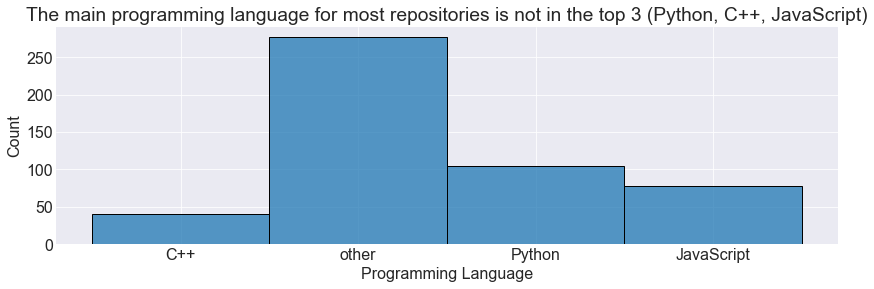

In [4]:
# Here we'll create a plot of the distribution of the target variable "language".

plot_target_distribution(df)

We can see here that the main programming language for most repositories is not one of the top 3 programming languages. However, the "other" class makes up roughly half of the data as we can see below.

In [7]:
print(f'Percentage of data classified as "other": {df[df.language == "other"].shape[0] / df.shape[0]:.0%}')

Percentage of data classified as "other": 55%


Since there is an even split between the top 3 programming languages and all other programming languages we consider the data to reasonably uniform for our purposes. This allows for accuracy to be a good metric to use for measuring model performance.

### Can the presence of certain keywords be used to identify the main programming language for a repository?

We are interested in knowing if keywords that are unique to a programming language appear in the READMEs. For instance, if the main programming language for a repository is Python are we likely to find terms such as "python", "pip", and "pandas" (which are unique to Python) in the repository. The visualization below will show some of the most frequently occuring words in repositories for each of the top 3 most common programming languages.

*Important Note:*
We are excluding keywords that are common to all repositories in order to display those keywords that are unique to each of the top 3 programming languages. For example, the data we have are READMEs from repositories that match the search term "bitcoin" so the word "bitcoin" is very common across all the repositories. There isn't much value in knowing that "bitcoin" is a common word in READMEs where the main programming language is, for instance, Python so words like this are excluded from the visualizations below.

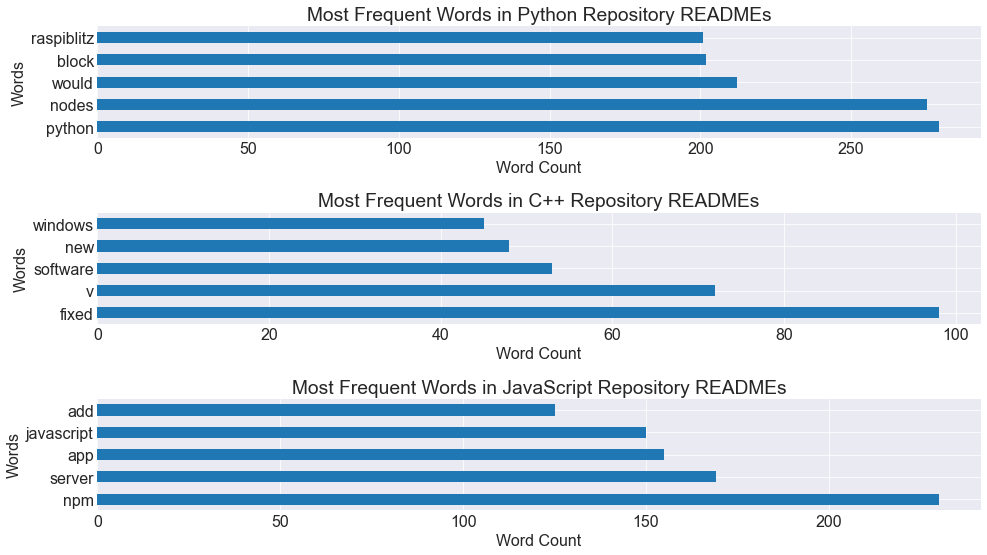

In [3]:
# Here we'll plot the most frequent words for each of the top 3 programming languages not including words that are 
# common across all programming languages.

plot_most_frequent_words(df)

Some of the words that appear here aren't particularly helpful, such as "add" and "would". However, what this visualization tells us is that we can expect certain keywords to appear in the README that will give us immediate insight into the main programming language for the repository. These are words such as "python" and "javascript". With this in mind we can create lists of keywords that are unique to each programming language and have a features that indicate whether or not these keywords exist in the README.

Below we'll show visualizations that display how many of the top 3 programming languages can be identified by finding keywords in the README.

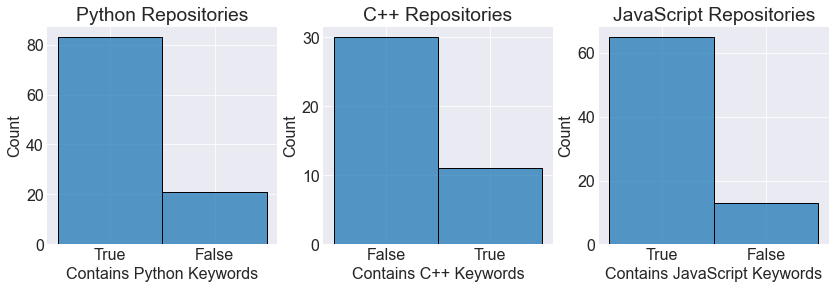

In [4]:
# Here we'll create plots of the number of READMEs that have language specific keywords for each of the top 3 
# programming languages.

plot_contains_keywords(df)

**Takeaways:**
For Python and JavaScript repositories we can identify the main programming language for the repository in many cases by identifying whether or not certain keywords exist in the README file. For C++ repositories this strategy does not work as often since there aren't many keywords that are unique to C++ that are frequently used in the README files. However, these can still prove useful at least for identifying repositories where Python or JavaScript are the main programming languages.

### Are there bi-grams that are unique to one of the top 3 most common programming languages?

Sometimes looking at unique combinations of consecutive words, or bi-grams, can be more helpful than looking at the individual words in a text document. We are interested in determining whether or not there are common bi-grams in the data that are uniquely different from the frequent words we discovered in the previous question. If there are, this could provide us with an additional approach that we can pursue when building machine learning models. Below we'll see some visualizations of the most common bi-grams for each of the top 3 most common programming languages.

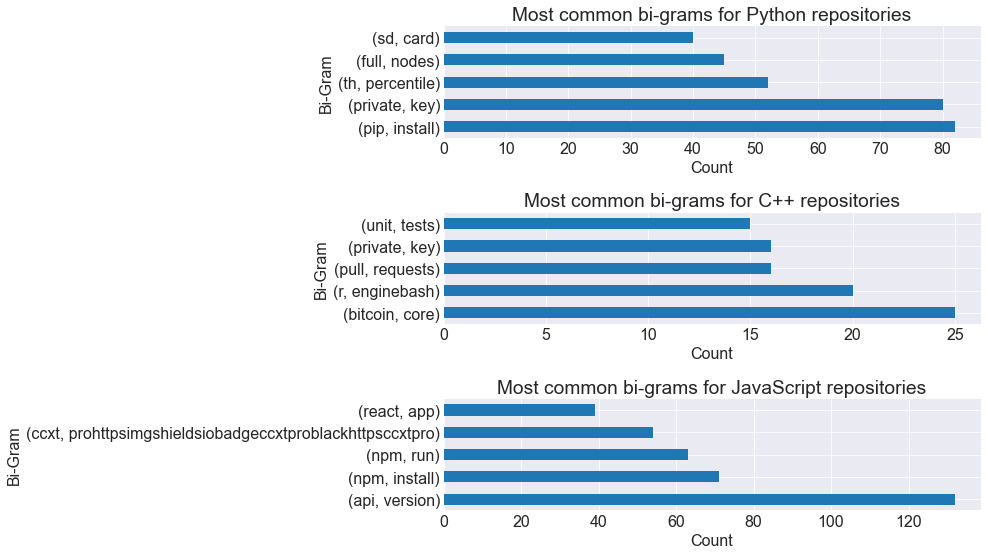

In [18]:
# Here we'll plot the top 5 most common bi-grams for each of the top 3 most common programming languages.

plot_bigrams(df)

**Takeaways:**
There are some bi-grams that would appear to be unique to certain programming languages, such as "pip install" for python and "npm install" for JavaScript. We could potentially try creating some models that utilize bi-grams in a count or tfidf vectorizer. This also provides an opportunity to add to the lists of unique keywords that the features engineered from the previous section utilize.

Overall though, there are bi-grams unique to the various target classes which means that there is value in utilizing bi-grams as a means to predict the main programming language for a repository.

### Is there a statistically significant difference between README lengths from the top 3 most common languages?

We are interested in knowing if the average size of a README file varies significantly depending on the main programming language for the repository. To determine this we have a feature that contains the total number of characters contained within the cleaned README text and we group the data by the programming language and get the average character count for each group. Below we see a visualization showing the results.

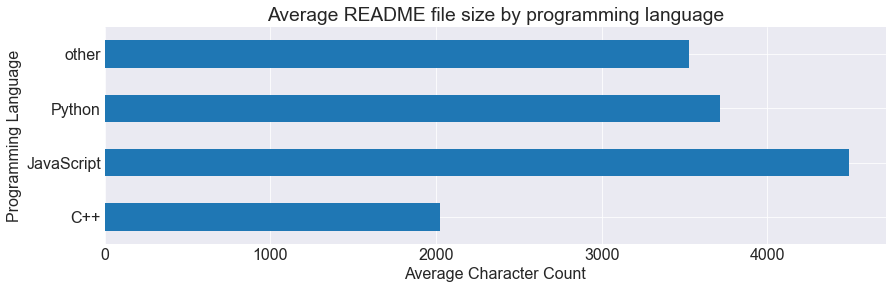

In [5]:
# Here we'll plot the average character count for each README grouping by the main programming language for the 
# repository.

plot_readme_size_vs_language(df)

We can get two insights from this chart. First, the average size of the README.md file for repositories where the main programming language is JavaScript is greater than for any other programming language. Second, the average size of the README.md file for repositories where the main programming language is C++ is less than for any other programming language.

We can verify that these difference are significant and not by chance using statistical tests. Below we will conduct two statistical tests to determine if JavaScript repositories have READMEs that are on average significantly larger than for other programming languages and if C++ repositories have READMEs that are on average significantly smaller than for other programming languages.

First we'll test the following hypothesis:

$H_0$: The average character count for READMEs in JavaScript repos is equal to the average character count for all READMEs.
<br>
$H_a$: The average character count for READMEs in JavaScript repos is greater than the average character count for all READMEs.

In [6]:
# Here we'll conduct a one sample t-test between all repos where the main programming language is JavaScript 
# and the entire population of repositories. We'll test for a significant difference in character_count. 
# This will be a one sided t-test testing for JavaScript repositories having READMEs that are significantly 
# larger than other READMEs.

one_sample_ttest(df, df[df.language == 'JavaScript'], 'readme_size', 'greater')

Reject H0


The results are that the null hypothesis is rejected meaning that JavaScript repositories do have READMEs that are significantly larger in size than other programming languages.

Next we'll test the following hypothesis:

$H_0$: The average character count for READMEs in C++ repos is equal to the average character count for all READMEs.
<br>
$H_a$: The average character count for READMEs in C++ repos is less than the average character count for all READMEs.

In [7]:
# Here we'll conduct a one sample t-test between all repos where the main programming language is C++ 
# and the entire population of repositories. We'll test for a significant difference in character_count. 
# This will be a one sided t-test testing for C++ repositories having READMEs that are significantly 
# smaller than other READMEs.

one_sample_ttest(df, df[df.language == 'C++'], 'readme_size', 'less')

Fail to reject H0


The results are that we fail to reject the null hypothesis meaning that we cannot say that there is a significant difference in the size of READMEs for repositories where the main programming language is C++.

**Takeaways:**
While we can't say that there is a significant difference in the size of a README for all programming languages we can say for JavaScript that there is a significant difference in the average size of the README file. With this information we can use the readme_size feature in our models to potentially distinguish the main programming language for a given repository.

### Key Takeaways

We discovered that there are certain words that are unique to various programming languages. These are words such as "python" and "pip" for Python, and "js", "javascript", and "npm" for JavaScript. With this in mind we can be confidant that it is possible to identify the main programming language for a repository given the README.md file. While training our machine learning model, the model will probably be able to pick up on these patterns, but we can also engineer features to identify a variety of unique keywords in order to produce a model that would be robust to new observations.

Additionally, there are also bi-grams, or combinations of two consecutive words, that are unique to various programming languages. This too could prove beneficial in training a machine learning model, but also helps us identify additional keywords to be aware of. Overall, whether using single words or bi-grams there do exist patterns in the data that indicate it would be possible to identify the main programming language for a repository from the existence of certain words in the README.md file.

We also discovered that for JavaScript repostories there is a significant difference the size of the README.md file on average compared to the average size of the README.md file for other programming languages. A statistical test helped us come to this conclusion and could prove useful in modeling.

To conclude, in modeling we will be using single words, bi-grams, the existence of keywords, and the total character count of the README file to train our models to predict the main programming language for a repository.

___
## Modeling

In the modeling phase many different models were created to find the best model to predict the language of the repo's `README.md`. Various machine learning algorithms were used with a variety of hyper-parameters. Also different numbers of features were used to determine if the number of features would change the performance of a model. In total 6 different models were produced and evaluated.

In this project we primarily use accuracy to measure the performance of our models since there is a fairly even split between false positives and confirmed languages. In the case when two models have similar accuracy the precision score will help break the tie since we want to be sure of our positive predictions.

### Tidy Data Split

We start by tidying the data for a supervised machine learning model. We take the prepared data from above and isolate the target from the features. In this case, the target, (y), is `'language'` and the feature, (X), is the prepared  `README.md` document. Both, feature and target, are further divided into train, test, and validate dataframes. 

In [10]:
# return train, validate, test splits for supervised machine learning
# the target (y) is isolated from the features (X)
# a modeling set is returned for the cleaned, trimmed, and lemmatized corpora

(X_lem_train,X_lem_validate, X_lem_test,

y_lem_train, y_lem_validate, y_lem_test,

X_stem_train, X_stem_validate, X_stem_test,

y_stem_train, y_stem_validate, y_stem_test,

X_clean_train, X_clean_validate, X_clean_test,

y_clean_train, y_clean_validate, y_clean_test) = model_prep(df)

Below is an example of the feature, (X), and target, (y), data frames for the lematized, training corpus.

In [11]:
print(X_lem_train.head(),'\n')
print(y_lem_train.head())


                                            lemmatized
368  bitcoin interest bitcoin interest fork bitcoin...
94   haskoin core haskoin core library bitcoin bitc...
353  cashaddressorg javascript clientside bitcoin c...
243  notice end work notice due lack time support r...
105  planning chaincode residencyhttpsresidencychai... 

368         other
94          other
353         other
243    JavaScript
105         other
Name: language, dtype: object


### Decision Tree Classification Model

This particular corpus lends itself perfectly to a classification model. Therefore, we will use a decision tree to predict which programming language each `README.md` is referencing.  

Classification models are a type of supervised machine learning model that attempts to separate the individual documents, (X), into unique classes. In order for our supervised models to work, we must teach them our programming languages, (y), first. To help the training process, we've engineered 2 features for our model. Both are designed to assign a number for the occurrence of each word in our document. Once our model has been trained, we can use it on an unknown, validation dataset.


There are several methods that a classification algorithm may use. In this project we choose the decision tree approach. A decision tree splits our features, (X), into
two groups. Every iteration of the two groups is measured and given a "gini" score. The higher the "gini" score, the better our model did at putting "Python" documents into the "Python" class and "JavaScript" in its respective class as well. After the first round of splitting, the process is repeated until every document is labeled.

This approach is very effective at labeling every feature, (X), in fact, we need to be careful of over fitting. To ensure our model is capable of predicting the class of unknown documents, we will use a validate dateset to measure it's consistency.

### NLP Model Analysis

The graph below shows the results of our classification model. Our specific decision tree has a max depth of 5 splits. This will help to prevent over fitting. The model is run on all 3 of our prepared corpora, "clean", "stemmed", and "lemmatized". Each corpus was engineered for easier processing by the model. The features were engineered using a count vectorizer (CV) and a TF-IDF vectorizer (TF-IDF). 

Both vectorizers quantify how frequently a word appears in a document, albeit, in different manners. The CV simply counts how many times a word appears and creates a list with the tally for every word. The TF-IDF, which stands for Term Frequency over Inverse Document Frequency is a ratio which attempts to assign value to the individual words. Words with a higher TF-IDF, are more heavily weighted and can therefore help our model find correct meaning.

From the graph below we can clearly see which model has the best accuracy. Our decision tree model using lemmatized data with TF-IDF engineering performs better than the other combinations. 


Text(0, 0.5, 'Accuracy [ % ]')

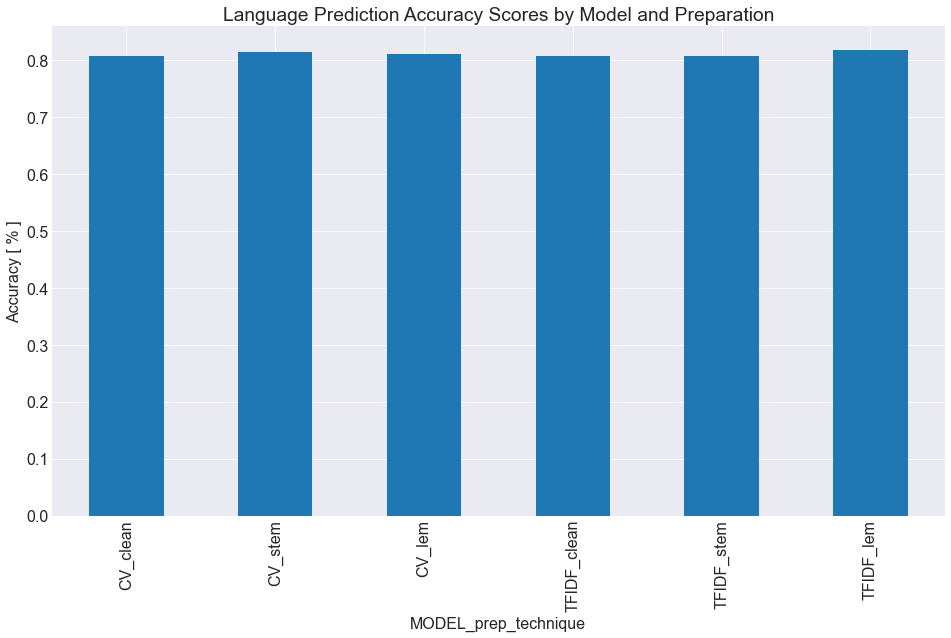

In [12]:
# display the accuracy results for each of the models
# pulls the score from prepare.py
dec_tree_training_scores=classi_bow(X_lem_train,y_lem_train,X_stem_train,y_stem_train,X_clean_train,y_clean_train)
# plot accuracy scores
dec_tree_training_scores.plot.bar()
plt.title('Language Prediction Accuracy Scores by Model and Preparation')
plt.xlabel('MODEL_prep_technique')
plt.ylabel('Accuracy [ % ]')

### Evaluating on Validate

The three decision tree models that utilize the tfidf vectorizer had the best performance on the train dataset so we will now evaluate these three models on the unseen validate dataset.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Make TF/IDF vectorizer object
tfidf_clean = TfidfVectorizer()
# Fit_transform vectorizer on train data to make bag of words (bow)
tfidf_clean_bow = tfidf_clean.fit_transform(X_clean_train.clean)
# Make Decision Tree object
tfidf_clean_tree = DecisionTreeClassifier(max_depth=5)
# Fit decision tree to train data
tfidf_clean_tree.fit(tfidf_clean_bow, y_clean_train)
# Run function to get tree score on validate data
tfidf_clean_tree_valscore = get_dt_valtest_score(tfidf_clean_bow, X_clean_train.clean, X_clean_validate.clean, y_clean_validate, tfidf_clean_tree)


# Make TF/IDF vectorizer object
tfidf_stem = TfidfVectorizer()
# Fit_transform vectorizer on train data to make bag of words (bow)
tfidf_stem_bow = tfidf_stem.fit_transform(X_stem_train.stemmed)
# Make Decision Tree object
tfidf_stem_tree = DecisionTreeClassifier(max_depth=5)
# Fit decision tree to train data
tfidf_stem_tree.fit(tfidf_stem_bow, y_stem_train)
# Run function to get tree score on validate data
tfidf_stem_tree_valscore = get_dt_valtest_score(tfidf_stem_bow, X_stem_train.stemmed, X_stem_validate.stemmed, y_stem_validate, tfidf_stem_tree)



# Make TF/IDF vectorizer object
tfidf_lem = TfidfVectorizer()
# Fit_transform vectorizer on train data to make bag of words (bow)
tfidf_lem_bow = tfidf_lem.fit_transform(X_lem_train.lemmatized)
# Make Decision Tree object
tfidf_lem_tree = DecisionTreeClassifier(max_depth=5)
# Fit decision tree to train data
tfidf_lem_tree.fit(tfidf_lem_bow, y_lem_train)
# Run function to get tree score on validate data
tfidf_lem_tree_valscore = get_dt_valtest_score(tfidf_lem_bow, X_lem_train.lemmatized, X_lem_validate.lemmatized, y_lem_validate, tfidf_lem_tree)



In [15]:
# Output tree score on validate
print(f'Score of Decision Tree using TF/IDF Vectorizer on clean text for validate split: {tfidf_clean_tree_valscore:.0%}')
print(f'Score of Decision Tree using TF/IDF Vectorizer on stem text for validate split: {tfidf_stem_tree_valscore:.0%}')
print(f'Score of Decision Tree using TF/IDF Vectorizer on lem text for validate split: {tfidf_lem_tree_valscore:.0%}')

print(f'Difference: {tfidf_clean_tree_valscore - tfidf_lem_tree_valscore}')


Score of Decision Tree using TF/IDF Vectorizer on clean text for validate split: 72%
Score of Decision Tree using TF/IDF Vectorizer on stem text for validate split: 68%
Score of Decision Tree using TF/IDF Vectorizer on lem text for validate split: 71%
Difference: 0.008333333333333304


**Takeaways:**
On the validate split, a Decision Tree model using the TF/IDF vectorizer on any of the three preparations is over 75% accurate at determining the programming language corresponding to a given repo's README. Lemmatized text was expected to be the most accurate, but the clean and stemmed preparations were both just slightly more accurate by less than a percentage point.

There was less dropoff for the clean preparation than the stemmed preparation so a Decision Tree model using the TF/IDF vectorizer on the clean text preparation will be evaluated on unseen test split data.

### Evaluating the Best Model on Test

With our best model chosen we will now evaluate on the test dataset to determine how this model can be expected to perform on unseen data in practice.

In [16]:
tfidf_clean_tree_testscore = get_dt_valtest_score(tfidf_clean_bow, X_clean_train.clean, X_clean_test.clean, y_clean_test, tfidf_clean_tree)

print(f'Score of Decision Tree using TF/IDF Vectorizer on clean text for the test split: {tfidf_clean_tree_testscore:.0%}')

Score of Decision Tree using TF/IDF Vectorizer on clean text for the test split: 71%



___

## Key Takeaways and Recommendations

- Statistically significant differences in the average lengths of Javascript repo READMEs compared to the length of READMEs written for repos representing other programming languages. A classification model that can take this into account may see a boost in accuracy.

- The TF/IDF vectorizer, combined with any of our three text preparations, flatly outperforms the count vectorizer in terms of accuracy. 

___

## Next Steps

- Other types of models, including Naive Bayes, which we attempted but found too computationally costly to work on our dataset, could and should be evaluated. In the case of Naive Bayes, we will need to use a decidedly smaller and more selectively targeted set of features.

- Hyperparameter adjustment and different feature selection strategies should be more thoroughly explored.